# LSTM Model Explainability


In [2]:
import sys
sys.path.append('..')

In [3]:
import pandas as pd
import shap

from lib.read_data import read_and_join_output_file
from lib.deeplearning import get_train_test_datasets, get_sets_shapes

import tensorflow
from tensorflow import keras

In [4]:
tensorflow.compat.v1.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


## Loading the Data and LSTM Model
We load the dataset and the best LSTM model

In [5]:
RANDOM_SEED = 31
test_size=0.15
target_variable="GSE_GWE"
# Load the data from the ETL output files
X = read_and_join_output_file()
X.drop(["SHORTAGE_COUNT"], inplace=True, axis=1)
# Split the input pandas Dataframe into training and test datasets, applies the impute pipeline
# transformation and reshapes the datasets to 3D (samples, time, features) numpy arrays
X_train, X_test, y_train, y_test, impute_pipeline, impute_columns, target_scaler = get_train_test_datasets(X, target_variable=target_variable, test_size=test_size, random_seed=RANDOM_SEED, save_to_file=True)
model_predictions_df = pd.DataFrame(y_test, columns=[target_variable])
model_scores_df = pd.DataFrame(columns=["MAE", "MSE", "RMSE"])
nb_features = X_train.shape[-1]
get_sets_shapes(X_train, X_test)

,nb_items,nb_timestamps,nb_features
training dataset,406,7,80
test dataset,72,7,80


In [6]:
model = keras.models.load_model("../assets/models/keras_lstm_model")

## Initializing SHAP
We use the SHAP library to compute the SHAP value based on the Township-Ranges in the training data

In [7]:
shap.initjs()

In [8]:
# DeepExplainer to explain predictions of the model
lstm_explainer = shap.DeepExplainer(model, X_train)
# compute shap values
lstm_shap_values = lstm_explainer.shap_values(X_test)

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


## SHAP Global Interpretation
In the case of an LSTM model with test data of the format 72\ TownshipRanges\ *\ 7\ time stamps\ *\ 80\ features$ the SHAP values are also of the same format. SHAP thus computes SHAP values for each feature of each year.
### 2014 Most Important Features

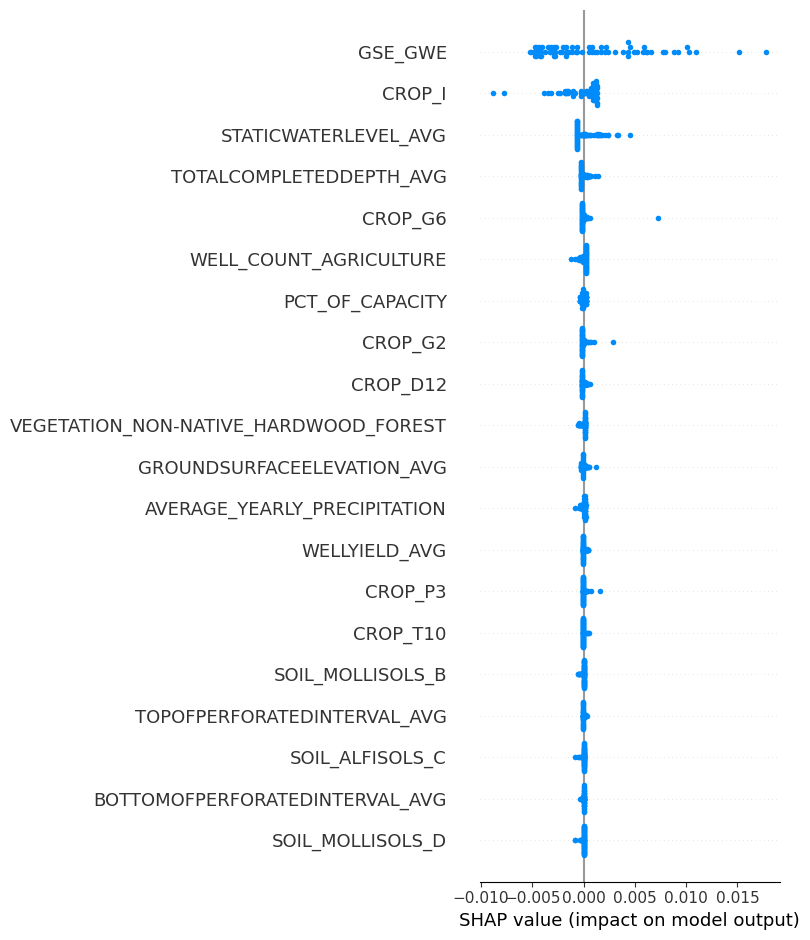

In [9]:
shap.summary_plot(lstm_shap_values[0][:,0,:], feature_names=impute_columns)

### 2015 Most Important Features

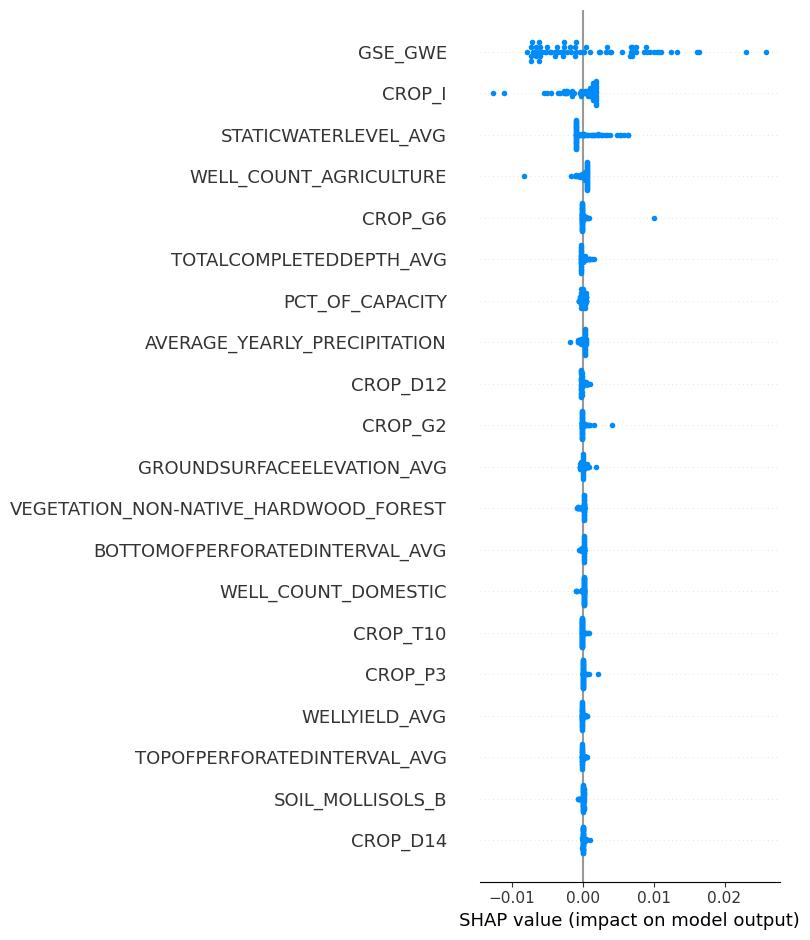

In [10]:
shap.summary_plot(lstm_shap_values[0][:,1,:], feature_names=impute_columns)

### 2016 Most Important Features

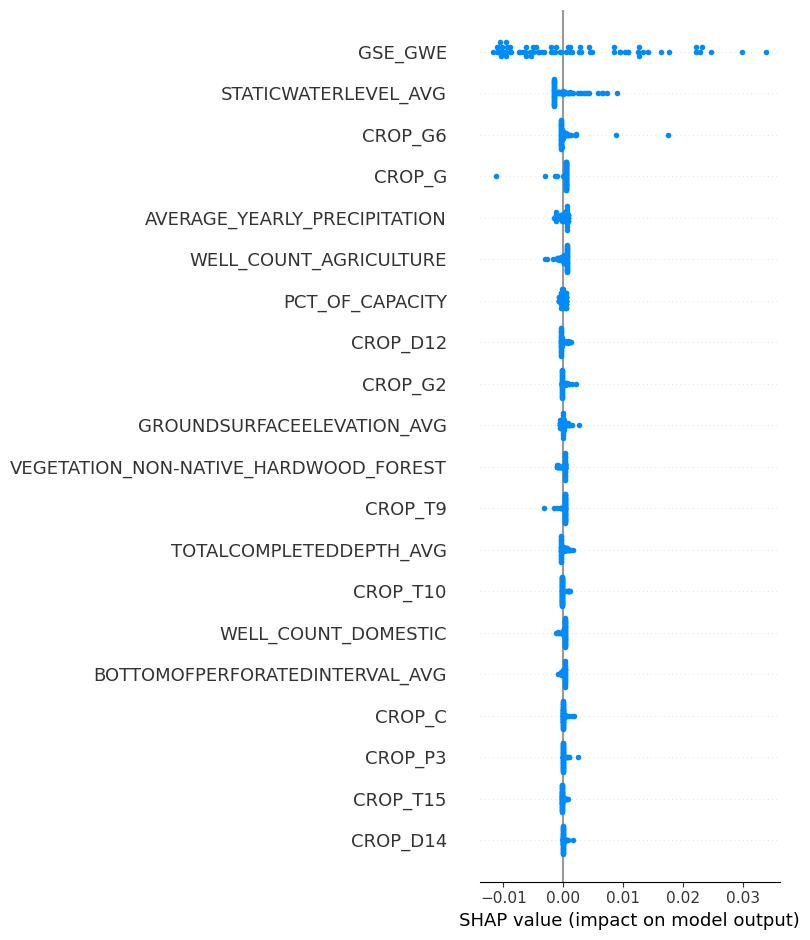

In [11]:
shap.summary_plot(lstm_shap_values[0][:,2,:], feature_names=impute_columns)

### 2017 Most Important Features

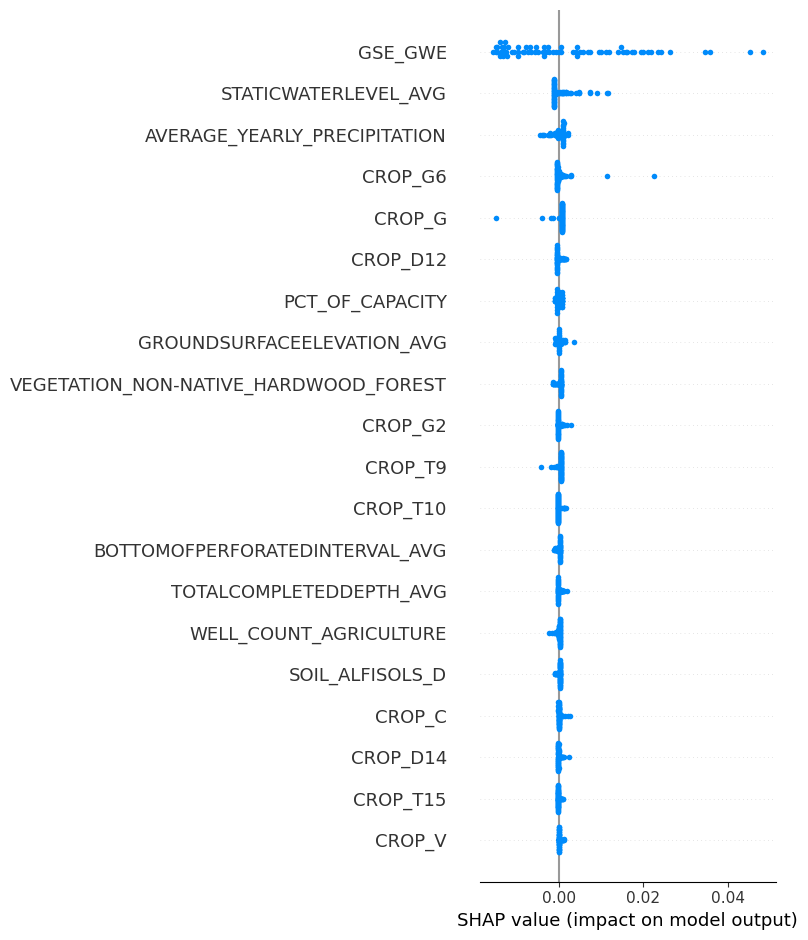

In [12]:
shap.summary_plot(lstm_shap_values[0][:,3,:], feature_names=impute_columns)

### 2018 Most Important Features

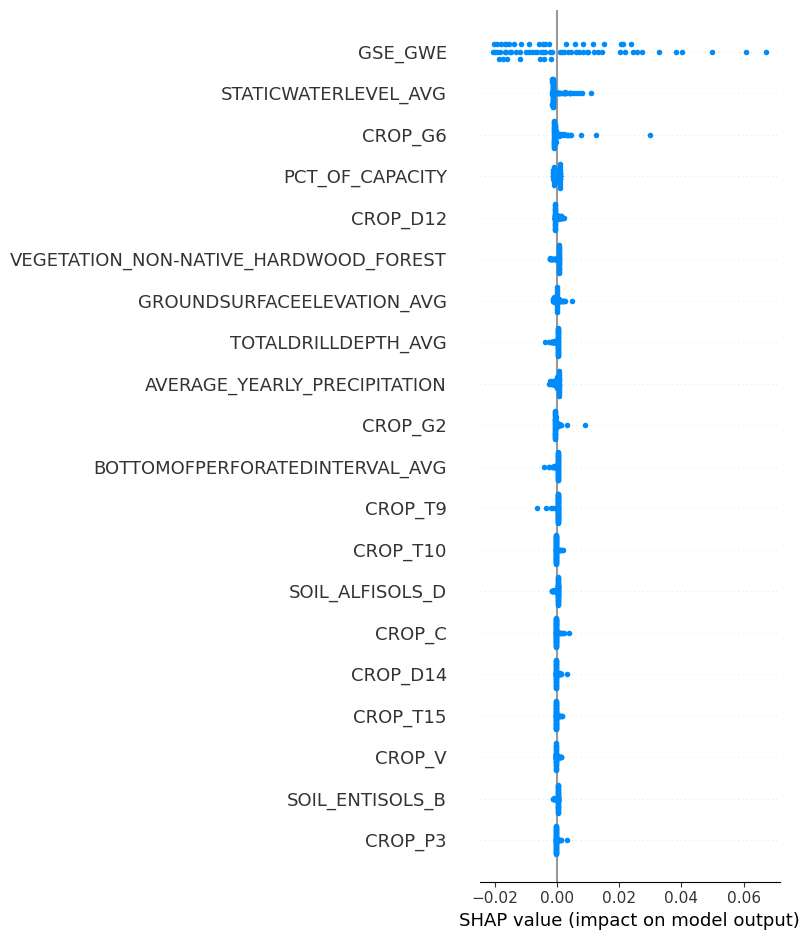

In [13]:
shap.summary_plot(lstm_shap_values[0][:,4,:], feature_names=impute_columns)

### 2019 Most Important Features

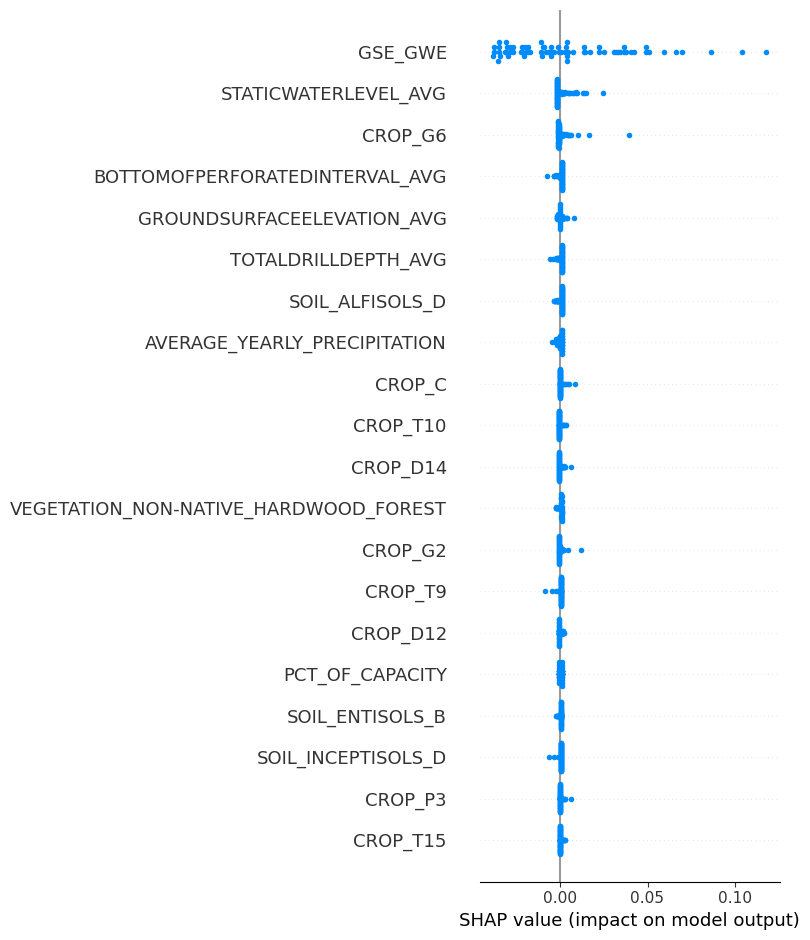

In [14]:
shap.summary_plot(lstm_shap_values[0][:,5,:], feature_names=impute_columns)

### 2020 Most Important Features

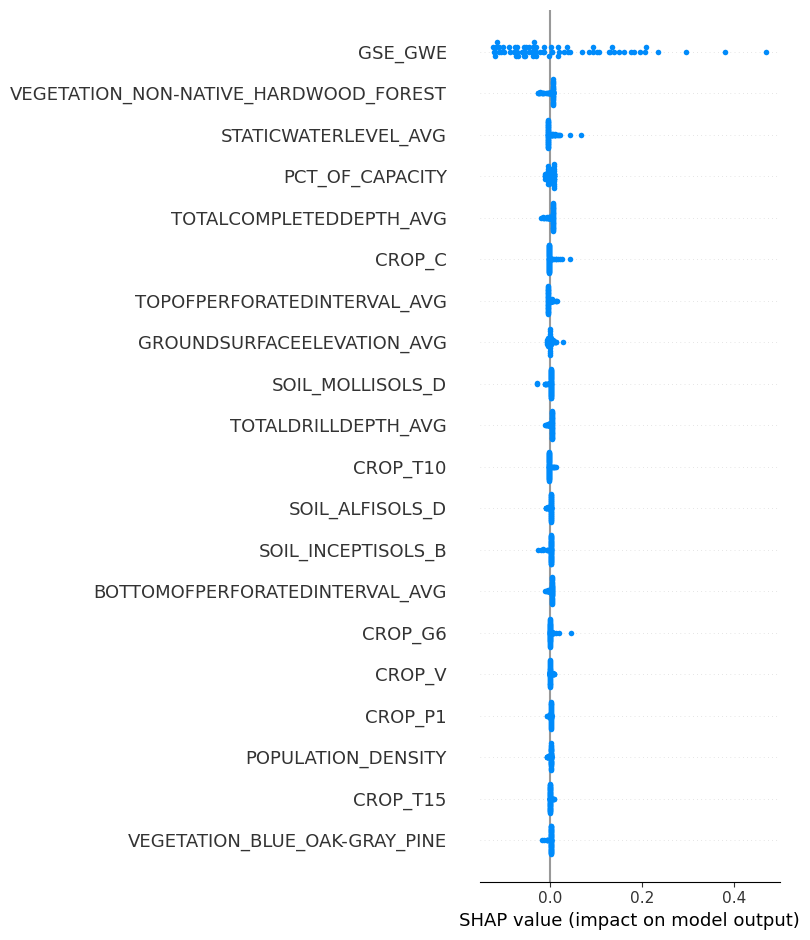

In [15]:
shap.summary_plot(lstm_shap_values[0][:,6,:], feature_names=impute_columns)

Looking at the top 5 features of each year, we can see that the important features explaining the predictions vary from year to year with the following trends:
* Like for machine learning models, the past `GSE_GWE` remain the best predicator for the 2021 predictions of the `GSE_GWE`of the LSTM model.
* The `STATICWATERLEVEL_AVG` (the distance from the land surface (or the measuring point) to the water in a well under non-pumping (static) conditions) is consitantly the second or third most important feature throughout all the years
* In the early years the `CROP_I` (idle, meaning there is no crops being raised on the farming land) and `TOTALCOMPLETEDDEPTH_AVG`
* From 2016 to 2018 the `AVERAGE_YEARLY_PRECIPITATION` plays an important role
* From 2016 to 2019 the crop `CROP_G6` (miscellaneous grain and hay) remains one of the main features explaining the predictions
* Only in 2019 are well measures `BOTTOMPERFORATEDINTERVAL_AVG` and `GROUNDSURFACEELEVATION_AVG` part of the top 5 most important features
* Like for the Random Forest and Support Vector Regression (SVR) models, the `VEGETATION_NON-NATIVE_HARDWOOD_FOREST` is the second most important features
* Soil features seem to globally have very little importance in the explainability of the model predictions

